In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 16
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import covid19

In [3]:
data = pd.read_csv('covid-19-it-protezione-civile.csv', parse_dates=['date'], index_col=['date'])
data['total_cases'] = data['cases'] + data['deaths'] + data['healed']

data

,cases,deaths,healed,critical,severe,total_cases
date,,,,,,
2020-02-21 16:00:00,19,1,0,0,0,20
2020-02-22 16:00:00,74,2,0,0,0,76
2020-02-23 16:00:00,149,3,0,0,0,152
2020-02-24 16:00:00,222,7,0,27,101,229
2020-02-25 16:00:00,311,10,1,35,114,322
2020-02-26 16:00:00,385,12,3,36,128,400
2020-02-27 16:00:00,588,17,45,56,248,650
2020-02-28 16:00:00,821,21,46,64,345,888
2020-02-29 16:00:00,1049,29,50,105,401,1128


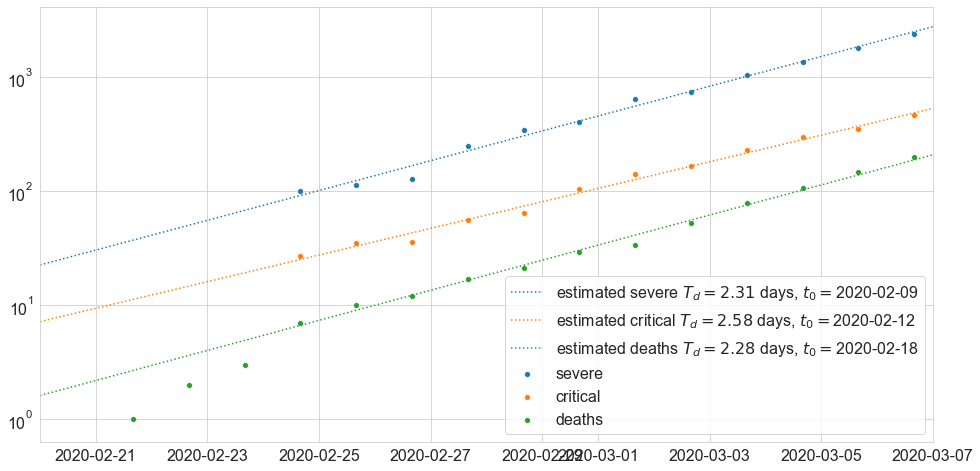

In [4]:
START_FIT = '2020-02-24'
EXTRAPOLTATE = ('2020-02-20', '2020-03-07')

fits = {}
for column in ['severe', 'critical', 'deaths']:
    fits[column] = covid19.fit.ExponentialFit.from_frame(column, data, start_fit=START_FIT)
    ax = covid19.plot.plot(data[column], fits[column], label=column, extrapolate=EXTRAPOLTATE)
    ax.set(yscale='log')
